# A Monte Carlo program for the Newman-Moore triangular lattice Ising model

In [1]:
using Random; Random.seed!(0); 
rng = MersenneTwister(1234);

const EqSteps = 500
const NumSteps = 50000 #Monte Carlo production steps

#k = 2
#L = 2^k
const L = 8
const N = L*L
Spin = fill(1,N);

In [2]:
#This is the data structure that relates up-triangles to spin indices
UpTriangle = zeros(Int,N,3)
for i = 1:N
    UpTriangle[i,1] = i
    UpTriangle[i,2] = i+1    
    UpTriangle[i,3] = i+L
    #fix PBCs
    if mod(i,L) == 0
        UpTriangle[i,2] = i + 1 - L
    end
    if (i+L)> N
        UpTriangle[i,3] = i + L - N
    end
end

In [3]:
#This is the inverse data structure that relates a spin index to its 3 up-triangles
AssociatedTri = zeros(Int,N,3)
for i = 1:N
    AssociatedTri[i,1] = i
    AssociatedTri[i,2] = i-1
    AssociatedTri[i,3] = i-L
    if mod(i-1+L,L) == 0
        AssociatedTri[i,2] = i - 1 + L
    end
    if i<(L+1) 
        AssociatedTri[i,3] = i + N - L
    end
end

In [4]:
#here is the brute force calculation of the energy
function Energy_Total(Energy,Spin)
    Energy = 0
    for i = 1:N
        Spin1 = Spin[UpTriangle[i,1]]
        Spin2 = Spin[UpTriangle[i,2]]
        Spin3 = Spin[UpTriangle[i,3]]
        Energy += 0.5 * Spin1 * Spin2 * Spin3  #J = 1
    end
    return Energy
end #Energy_Total

Energy_Total (generic function with 1 method)

In [5]:
#here is the energy DIFFERENCE calculated from the local triangular plaquettes
function Energy_Diff(Spin,spin_index)
    
    SpinCopy = copy(Spin)
    
    Tri1 = AssociatedTri[spin_index,1]
    Tri2 = AssociatedTri[spin_index,2]
    Tri3 = AssociatedTri[spin_index,3]

    local_e_before = 0
    Spin1 = SpinCopy[UpTriangle[Tri1,1]]
    Spin2 = SpinCopy[UpTriangle[Tri1,2]]
    Spin3 = SpinCopy[UpTriangle[Tri1,3]]
    local_e_before += 0.5 * Spin1 * Spin2 * Spin3  
    Spin1 = SpinCopy[UpTriangle[Tri2,1]]
    Spin2 = SpinCopy[UpTriangle[Tri2,2]]
    Spin3 = SpinCopy[UpTriangle[Tri2,3]]
    local_e_before += 0.5 * Spin1 * Spin2 * Spin3  
    Spin1 = SpinCopy[UpTriangle[Tri3,1]]
    Spin2 = SpinCopy[UpTriangle[Tri3,2]]
    Spin3 = SpinCopy[UpTriangle[Tri3,3]]
    local_e_before += 0.5 * Spin1 * Spin2 * Spin3  

    #flip the spin
    SpinCopy[spin_index] *= -1
    
    local_e_after = 0
    Spin1 = SpinCopy[UpTriangle[Tri1,1]]
    Spin2 = SpinCopy[UpTriangle[Tri1,2]]
    Spin3 = SpinCopy[UpTriangle[Tri1,3]]
    local_e_after += 0.5 * Spin1 * Spin2 * Spin3  
    Spin1 = SpinCopy[UpTriangle[Tri2,1]]
    Spin2 = SpinCopy[UpTriangle[Tri2,2]]
    Spin3 = SpinCopy[UpTriangle[Tri2,3]]
    local_e_after += 0.5 * Spin1 * Spin2 * Spin3  
    Spin1 = SpinCopy[UpTriangle[Tri3,1]]
    Spin2 = SpinCopy[UpTriangle[Tri3,2]]
    Spin3 = SpinCopy[UpTriangle[Tri3,3]]
    local_e_after += 0.5 * Spin1 * Spin2 * Spin3  
    
    #println(spin_index," ",local_e_before," ",local_e_after)
    
    return local_e_after - local_e_before
end

Energy_Diff (generic function with 1 method)

In [6]:
function MetropolisAccept(beta,DeltaE)::Bool
    if DeltaE <= 0
        return true
    else
        rnum = rand(rng)  #random number for Metropolis
        if (exp(-beta*DeltaE) > rnum)
            return true
        end
    end 
    return false
end

MetropolisAccept (generic function with 1 method)

In [7]:
Tarr = zeros(Float64,0)  
EMC = zeros(Float64,0)  
Eexact = zeros(Float64,0) 

for T = 2:-0.1:0.1  #count down
    
    beta = 1.0/T

    #initialize the energy
    Energy = 0
    Energy=Energy_Total(Energy,Spin)
    #println(Energy)

    for step = 1:EqSteps
        for i = 1:N  #multiple single spin flips
            spin_i = rand(1:N)
            DeltaE = Energy_Diff(Spin,spin_i)
            if MetropolisAccept(beta,DeltaE) == true
                Energy += DeltaE
                Spin[spin_i] *= -1
            end 
        end #i
    end #Equilibration
    
    E_avg = 0
    for step = 1:NumSteps
        for i = 1:N  #multiple single spin flips
            spin_i = rand(1:N)
            DeltaE = Energy_Diff(Spin,spin_i)
            if MetropolisAccept(beta,DeltaE) == true
                Energy += DeltaE
                Spin[spin_i] *= -1
            end 
        end #i
        E_avg += Energy
    end #Monte Carlo production step

    E_exact = 1/(1+exp(beta)) 
    println(T," ",E_avg/NumSteps/N," "," ",E_exact-0.5)
     
    push!(Tarr,T)
    push!(EMC,E_avg/NumSteps/N)
    push!(Eexact,E_exact-0.5)

end #T


2.0 -0.122626875  -0.1224593312018546
1.9 -0.128430625  -0.128623419215673
1.8 -0.1352534375  -0.1354235592583607
1.7 -0.143266875  -0.14296013786008316
1.6 -0.1510840625  -0.15135486466605425
1.5 -0.1606584375  -0.16075636876581717
1.4 -0.17136125  -0.17134745348272995
1.3 -0.1832440625  -0.183354470187783
1.2 -0.1972859375  -0.19705928396540728
1.1 -0.2127540625  -0.2128140986174974
1.0 -0.2312640625  -0.2310585786300049
0.9 -0.251975625  -0.2523361988609284
0.8 -0.2774721875  -0.2772998611746912
0.7 -0.30679375  -0.30667863019769126
0.6 -0.342085  -0.34113089511908484
0.5 -0.38077  -0.3807970779778824
0.4 -0.42407  -0.42414181997875644
0.3 -0.45224  -0.4655548043337888
0.2 -0.451405  -0.49330714907571516
0.1 -0.4531171875  -0.49995460213129755


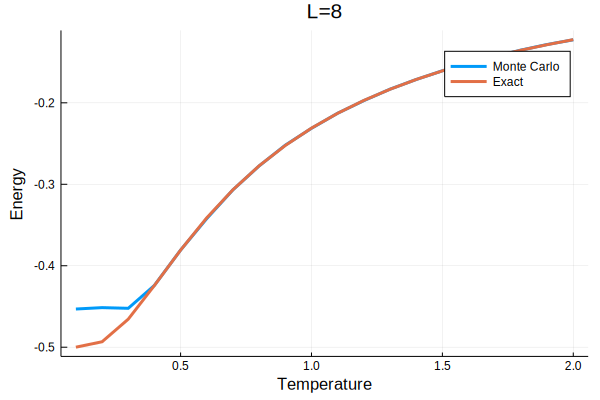

In [8]:
using Plots

plot(Tarr, [EMC, Eexact], title = "L=8", label = ["Monte Carlo" "Exact"], lw = 3 )
xlabel!("Temperature")
ylabel!("Energy")